[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jfcrenshaw/pzflow/blob/main/examples/redshift_example.ipynb)

If running in Colab, to switch to GPU, go to the menu and select Runtime -> Change runtime type -> Hardware accelerator -> GPU.

In addition, uncomment and run the following code:

In [1]:
# !pip install pzflow corner

-------------------
## Redshift example


In [1]:
import jax.numpy as np
import matplotlib.pyplot as plt
import corner

import pzflow
from pzflow import Flow
from pzflow.bijectors import Chain, RollingSplineCoupling, Softplus, ColorTransform, StandardScaler
from pzflow.examples import galaxy_data

First let's load the example galaxy data set included with `pzflow`.

In [2]:
data = galaxy_data()
data.head()

,redshift,u,g,r,i,z,y
0,0.287087,26.759261,25.901778,25.187710,24.932318,24.736903,24.671623
1,0.293313,27.428358,26.679299,25.977161,25.700094,25.522763,25.417632
2,1.497276,27.294001,26.068798,25.450055,24.460507,23.887221,23.206112
3,0.283310,28.154075,26.283166,24.599570,23.723491,23.214108,22.860012
4,1.545183,29.276065,27.878301,27.333528,26.543374,26.061941,25.383056


You can see the first column is redshift, and the subsequent columns are galaxy magnitudes in the 6 LSST bandpass filters. The data is in a Pandas DataFrame, which is the data format `pzflow` uses on the user-end.

Now we will build a normalizing flow to model this data. We will construct a bijector made of four parts:

**1. Rolling Spline Coupling** --  
This is a bijector that alternates [Neural Spline Couplings](https://arxiv.org/abs/1906.04032) and "Rolling" layers. It has 5 parameters:
- `nlayers` - The number of (Neural Spline, Roll()) couplets in the chain of bijectors
- `K` - The number of bins in the splines
- `B` - The range of the splines
- `hidden_layers` - the number of hidden layers in the neural network that calculates the spline bins and derivatives
- `hidden_dim` - the number of hidden dimensions in that same neural network

Only `nlayers` is required.
For this example, we will set `nlayers` = 7 to match the input dimension, and we will leave everything else to their default values.
Feel free to play around with changing the other parameters.

**2. Standard Scaler** --  
This is a bijector whose inverse scales the data dimensions so that they have mean zero and unit variance. This means that the Rolling Spline Couplings can target a roughly Normal distribution that this layer will then scale up/down and shift to the appropriate location. This makes training the splines easier and more stable.

**3. Softplus** --  
This is a bijector that applies a softplus transformation to the requested columns.
We will apply it to the redshift column to ensure that sampled redshifts are always positive.

**4. Color Transform** --  
This is a bijector that converts galaxy colors and a reference magnitude into galaxy magnitudes.
In this example:

$(\text{redshift}, \, r, \, u\!-\!g, \, g\!-\!r, \, r\!-\!i, \, i\!-\!z, \, z\!-\!y) \to  (\text{redshift}, \, u, \, g, \, r, \, i, \, z, \, y)$  

Placing this Color Transform very last in our chain of bijectors means that the normalizing flow is optimizing the Neural Spline parameters to map the Gaussian samples onto the galaxy colors, rather than the galaxy magnitudes.
This is useful, as redshift correlates more directly with galaxy colors.

We construct the total bijector by chaining these four bijectors together.

To understand the construction of this bijector, you need to remember that the bijector maps the latent space to the data space (or base distribution to target distribution). You can think of the first component of this bijector (the Rolling Spline Coupling) as the generative layer. This layer takes the Normal base distribution as input and outputs a distribution with the structure and correlations of the data space. The three layers that follow (i.e. the Standard Scaler, Softplus, and Color Transform) don't add more structure to the data, but rather perform a kind of post-processing. The Softplus just ensures that sampled redshifts are always positive, but the Standard Scaler and Color Transform are essentially the inverse of what you might have done in other contexts to pre-process the data before training. By attaching the inverse of these pre-processing steps to the end of the bijector, we no longer have to pre-process new data before training, or post-process any samples we draw from the flow.

Note it is sometimes easier to construct a complicated bijector by thinking about its inverse. Think of starting with your data, and applying a series of transformations to map the data to a Normal distribution:
1. The (inverse) color transform converts magnitudes to colors.
2. The (inverse) softplus relaxes the constraint that redshift > 0.
3. The (inverse) Standard Scaler scales each dimension so it has mean zero and unit variance.
4. Finally the (inverse) Rolling Spline Coupling maps the distribution to a Normal.

After constructing the bijector, we create the flow by instantiating a `Flow` object.
We have to give it the names of the columns in our data set, as well as the bijector we just created.

In [3]:
# set number of layers in the RollingSplineCoupling
# equal to the input dimension
nlayers = data.shape[1]

# calculate the mean and standard deviations of the dimensions
# note that on this side of the color transform, we are working
# in color space, so I calculate the mean and std dev of these 
# variables instead of the raw magnitudes
data_temp = np.array([data['redshift'], 
                      data['r'], 
                      data['u'] - data['g'], 
                      data['g'] - data['r'], 
                      data['r'] - data['i'], 
                      data['i'] - data['z'], 
                      data['z'] - data['y']]).T

means = data_temp.mean(axis=0)
stds = data_temp.std(axis=0)
del data_temp

# set the softplus parameters, to ensure
# that sampled redshifts are positive
column_idx = 0
sharpness = 10

# set the Color Transform reference index
# to use the r band as the reference magnitude
ref_idx = data.columns.get_loc("r")
# set the column indices for the magnitudes we want colors from
mag_idx = [data.columns.get_loc(col) for col in ["u","g","r","i","z","y"]]

# construct our bijector out of
# 1. a Rolling Spline Coupling
# 2. a Color Transform
bijector = Chain(
    RollingSplineCoupling(nlayers),
    StandardScaler(means, stds),
    Softplus(column_idx, sharpness),
    ColorTransform(ref_idx, mag_idx)
)

Now we will construct a normalizing flow with this bijector.
We create the flow by instantiating a `Flow` object.
We have to give it the names of the columns in our data set, as well as the bijector we just created.

In [4]:
# To create the normalizing flow, we have to provide
# 1. The names of the columns in our data set
# 2. The bijector
flow = Flow(data.columns, bijector)

Now we can train our normalizing flow.
This is as simple as calling `flow.train(data)`.
There are several training parameters you can set, including the number of epochs, the batch size, the optimizer, and the random seed.
See the documentation for the normalizing flow for more details.
For this example, let's set `epochs=200` and `verbose=True`.

*Warning:* this takes about 20 minutes to run on my CPU. (but only 4 minutes on a GPU!)

In [5]:
%%time
losses = flow.train(data, epochs=200, verbose=True)

Training 200 epochs 
Loss:
4.7522
-2.3613
-5.7527
-6.4174
-6.6221
-6.9754
-7.3623
-7.5741
-7.3159
-7.3300
-7.6405
-7.8905
-7.7581
-7.9339
-7.8217
-7.8635
-8.2492
-8.2554
-7.7902
-8.1895
-8.3750
CPU times: user 7min 34s, sys: 8min 47s, total: 16min 21s
Wall time: 5min 51s


Now let's plot the training losses to make sure everything looks like we expect it to...

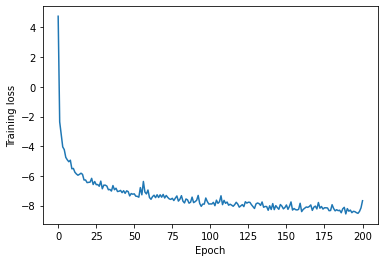

In [6]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.show()

Perfect!

Now we can draw samples from the flow, using the `sample` method.
Let's draw 10000 samples and make a corner plot, comparing these samples to the training set.

In [7]:
samples = flow.sample(10000, seed=0)

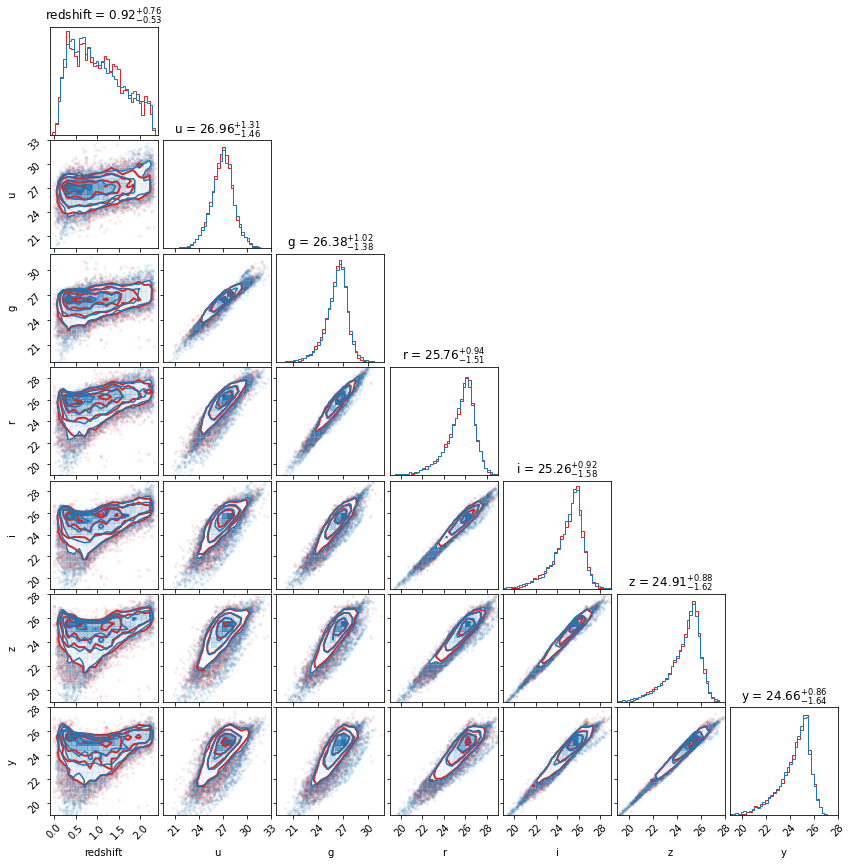

In [8]:
fig = plt.figure(figsize=(12,12))

ranges = [(-0.1,2.4), (19.5,33), (19,32), (19,29), (19,29), (19,28), (19,28)]

corner.corner(samples, fig=fig, color='C3', bins=20, range=ranges, hist_bin_factor=2, data_kwargs={'ms':3}, contour_kwargs={'linewidths':2})

corner.corner(data[:10000], fig=fig, bins=20, range=ranges, hist_bin_factor=2, color='C0', data_kwargs={'ms':3}, show_titles=True);

Looks great!

We can also use the flow to calculate redshift posteriors for galaxies using the `posterior` method.

In [9]:
grid = np.arange(0, 2.02, 0.02)
pdfs = flow.posterior(samples, column="redshift", grid=grid)

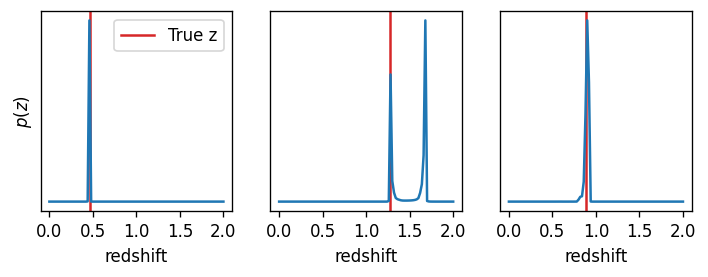

In [14]:
fig, axes = plt.subplots(1,3,figsize=(7,2.2), dpi=120)

idx = [0, 10, 31]
for i,ax in zip(idx, axes):
    true_z = samples['redshift'][i]
    ax.axvline(true_z, 0, 1, c="C3",
               label='True z')
    ax.plot(grid, pdfs[i])
    ax.set(xlabel="redshift",
           xticks=[0,0.5,1,1.5,2],
           yticks=[])
axes[0].legend()
axes[0].set(ylabel='$p(z)$')
plt.show()

We can also draw posteriors for magnitudes.
For example, lets draw posteriors for the $u$ band:

In [15]:
u_grid = np.arange(21, 30, 0.1)
u_pdfs = flow.posterior(samples, column='u', grid=u_grid)

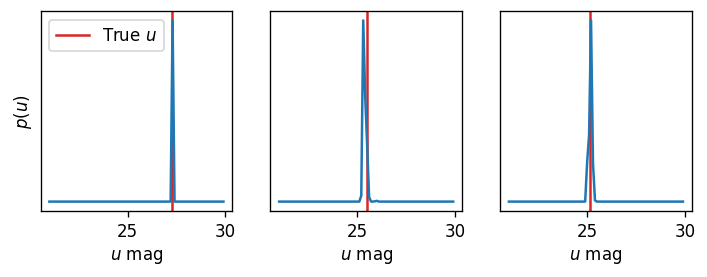

In [17]:
fig, axes = plt.subplots(1,3,figsize=(7,2.2), dpi=120)

idx = [0, 27, 79]
for i,ax in zip(idx, axes):
    true_u = samples['u'][i]
    ax.axvline(true_u, 0, 1, c="C3",
               label='True $u$')
    ax.plot(u_grid, u_pdfs[i])
    ax.set(xlabel="$u$ mag", 
           yticks=[])
axes[0].legend()
axes[0].set(ylabel='$p(u)$')
plt.show()

Now let's store some information with the flow about the data it was trained on.

In [18]:
flow.info = f"""
This is an example flow, trained on 100,000 simulated galaxies with 
redshifts in the range (0, 2.3) and photometry in the LSST ugrizy bands.

The data set used to train this flow is available in the `examples` module:
>>> from pzflow.examples import galaxy_data
>>> data = galaxy_data()

This flow was created with pzflow version {pzflow.__version__}
"""

In [19]:
print(flow.info)


This is an example flow, trained on 100,000 simulated galaxies with 
redshifts in the range (0, 2.3) and photometry in the LSST ugrizy bands.

The data set used to train this flow is available in the `examples` module:
>>> from pzflow.examples import galaxy_data
>>> data = galaxy_data()

This flow was created with pzflow version 1.4.0



Now let's save the flow to a file that can be loaded later:

In [20]:
flow.save("example-flow.pkl")

This file can be loaded on Flow instantiation:

In [21]:
flow = Flow(file="example-flow.pkl")

This example flow is also packaged with `pzflow`, so you can load it and play with it whenever you want:

In [23]:
from pzflow.examples import example_flow
flow = example_flow()

See! It's the same one:

In [24]:
print(flow.info)


This is an example flow, trained on 100,000 simulated galaxies with 
redshifts in the range (0, 2.3) and photometry in the LSST ugrizy bands.

The data set used to train this flow is available in the `examples` module:
>>> from pzflow.examples import galaxy_data
>>> data = galaxy_data()

This flow was created with pzflow version 1.4.0

